In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gpflow
import pickle
import os
import scipy
from GPSat import GlobalInterpolation, GPflowGPRExpert
from GPSat.post_process import PostProcessModule, clip_and_smooth
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Disable GPU. Somehow not working today

2022-11-08 21:48:22.754747: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-08 21:48:22.882963: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-08 21:48:23.398472: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.4/lib64:/usr/local/cuda-11.4/lib64
2022-11-08 21:48:23.398529: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; d

In [2]:
########## Process data ##########

# --- Read auxiliary data

# Get SIE mask
data_dir = "/home/so/Documents/Projects/GPSat/data/sea_ice_data/"
pkl_file = "aux/SIE/SIE_masking_50km_2018-2019_season.pkl"
pkl_full = os.path.join(data_dir, pkl_file)
with open(pkl_full, "rb") as f:
    SIE = pickle.load(f) # Dictionary {date: array}
dates = list(SIE.keys())

# Get x, y coordinates
x_file = os.path.join(data_dir, "aux/new_x_50km.npy")
y_file = os.path.join(data_dir, "aux/new_y_50km.npy")
xgrid = np.load(x_file)
ygrid = np.load(y_file)
xcoords = xgrid[0,:]
ycoords = ygrid[:,0]

# --- Get satellite observations (CS2_SAR, CS2_SARIN, S3A, S3B)

# CS2 SAR
pkl_file = "CS2S3_CPOM/CS2_SAR_dailyFB_50km_2018-2019_season.pkl"
pkl_full = os.path.join(data_dir, pkl_file)
with open(pkl_full, "rb") as f:
    CS2_SAR = pickle.load(f) # Dictionary {date: array}

# CS2_SARIN
pkl_file = "CS2S3_CPOM/CS2_SARIN_dailyFB_50km_2018-2019_season.pkl"
pkl_full = os.path.join(data_dir, pkl_file)
with open(pkl_full, "rb") as f:
    CS2_SARIN = pickle.load(f) # Dictionary {date: array}

# S3A
pkl_file = "CS2S3_CPOM/S3A_dailyFB_50km_2018-2019_season.pkl"
pkl_full = os.path.join(data_dir, pkl_file)
with open(pkl_full, "rb") as f:
    S3A = pickle.load(f) # Dictionary {date: array}

# S3B
pkl_file = "CS2S3_CPOM/S3B_dailyFB_50km_2018-2019_season.pkl"
pkl_full = os.path.join(data_dir, pkl_file)
with open(pkl_full, "rb") as f:
    S3B = pickle.load(f) # Dictionary {date: array}

# --- Convert data to numpy arrays (taken from Will's code)

obs = []
zb = []
dates = []
for key in CS2_SAR:
    if (key in CS2_SARIN) & (key in S3A) & (key in S3B):
        obs.append([CS2_SAR[key],CS2_SARIN[key],S3A[key],S3B[key]])
        zb.append(SIE[key])
        dates.append(key)
obs = np.array(obs).transpose(2,3,0,1) # (x, y, t, sat)
zb = np.array(zb).transpose(1,2,0)
zb[zb<0.15] = np.nan

T=9 # 9 days of data are used to train the model. You could test varying this. Could maybe get away with 5 or 7.
T_mid=T//2 # interpolate on the central day
dX, dY = obs.shape[0], obs.shape[1]
first_day = 100 #training data starts at day = 1
zb_day = zb[:,:,first_day+T_mid] #this is the sea ice extent mask on the day we are interpolating (i.e., we need to make sure there is sea ice where we want to estimate freeboard)
sat = obs[:,:,first_day:first_day+T,:] #the T days of training data from all satellites

# this next part loops over all T days of training data and appends all the inputs/outputs into long vectors
x1 = [] ; y1 = [] ; t1 = [] ; z1 = []
x2 = [] ; y2 = [] ; t2 = [] ; z2 = []
x3 = [] ; y3 = [] ; t3 = [] ; z3 = []
x4 = [] ; y4 = [] ; t4 = [] ; z4 = []
for day in range(sat.shape[3]):
    IDs_1 = np.where(~np.isnan(sat[:,:,day,0]))
    IDs_2 = np.where(~np.isnan(sat[:,:,day,1]))
    IDs_3 = np.where(~np.isnan(sat[:,:,day,2]))
    IDs_4 = np.where(~np.isnan(sat[:,:,day,3]))
    x1.extend(xgrid[IDs_1]) ; x2.extend(xgrid[IDs_2]) ; x3.extend(xgrid[IDs_3]) ; x4.extend(xgrid[IDs_4])
    y1.extend(ygrid[IDs_1]) ; y2.extend(ygrid[IDs_2]) ; y3.extend(ygrid[IDs_3]) ; y4.extend(ygrid[IDs_4])
    t1.extend(np.ones(np.shape(IDs_1)[1])*day) ; t2.extend(np.ones(np.shape(IDs_2)[1])*day) ; t3.extend(np.ones(np.shape(IDs_3)[1])*day) ; t4.extend(np.ones(np.shape(IDs_4)[1])*day)
    z1.extend(sat[:,:,day,0][IDs_1]) ; z2.extend(sat[:,:,day,1][IDs_2]) ; z3.extend(sat[:,:,day,2][IDs_3]) ; z4.extend(sat[:,:,day,3][IDs_4])
x_train = np.concatenate((x1,x2,x3,x4))
y_train = np.concatenate((y1,y2,y3,y4))
t_train = np.concatenate((t1,t2,t3,t4))
z_train = np.concatenate((z1,z2,z3,z4)).reshape(-1,1)

# Test points
IDs = np.where(~np.isnan(zb_day))
X_test = np.array([xgrid[IDs],ygrid[IDs]]).T

xy_train = np.array([x_train,y_train]).T
X_tree = scipy.spatial.cKDTree(xy_train)


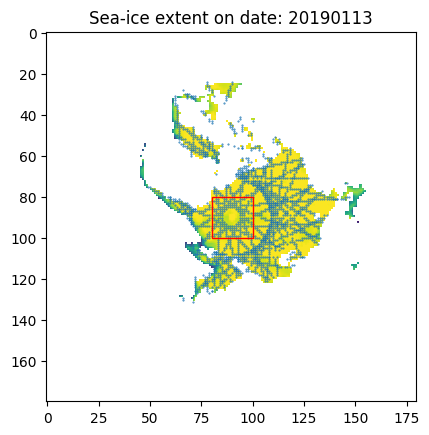

In [3]:
# Choose small region to test over
test_day = first_day + T_mid # Test date
xmin = 80; xmax = 100; ymin=80; ymax=100 # Region
Nx = xmax-xmin
Ny = ymax-ymin
x_test = np.array([xgrid[0,j] for j in range(xmin, xmax)])
y_test = np.array([ygrid[i,0] for i in range(ymin, ymax)])

x_idxs = []; y_idxs = []
for i in range(4):
    x, y = np.where(np.isnan(obs[:,:,test_day,i]) == False)
    x_idxs.extend(x); y_idxs.extend(y)
x_idxs = np.array(x_idxs); y_idxs = np.array(y_idxs)

# Plot sea ice extent at given date, selected region and satellite observatiosn
plt.imshow(zb[:,:,test_day].transpose())
plt.scatter(x_idxs, y_idxs, s=0.2)
plt.title(f"Sea-ice extent on date: {dates[test_day]}")
rect = patches.Rectangle((xmin, ymin), Nx, Ny, linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca()
ax.add_patch(rect)
plt.show()

In [5]:
# Set up
X = np.stack([x_train, y_train, t_train], axis=1)
z = z_train.reshape(-1,1)
dates = [dates[test_day]]
region = xr.Dataset(coords={"x": x_test, "y": y_test})
init_hyperparameters = {'lengthscale_x': 50*1000, 'lengthscale_y': 50*1000, 'lengthscale_t': 1.0, 'kernel_variance': 1.0, 'observation_variance': 1.0}
                        
postprocess_kwargs = {'lengthscale_x': {'vmin': 1, 'vmax': 2 * 300 * 1000, 'std': 1},
                      'lengthscale_y': {'vmin': 1, 'vmax': 2 * 300 * 1000, 'std': 1},
                      'lengthscale_t': {'vmin': 0.1, 'vmax': 9, 'std': 1},
                      'kernel_variance': {'vmin': 2e-6, 'vmax': 0.1, 'std': 1},
                      'observation_variance': {'vmin': 2e-6, 'vmax': 0.05, 'std': 1}
                      }

# Set up global interpolation model and train
local_expert = GPflowGPRExpert(kernel_cls=gpflow.kernels.Matern32,
                               parameters=init_hyperparameters)
                               
post_process = PostProcessModule(clip_and_smooth)

f = GlobalInterpolation(training_data=(X,z),
                        local_expert=local_expert,
                        dates=dates,
                        region=region,
                        post_process=post_process)

f.train(postprocess_kwargs)


Training on date: 20190113


/home/so/Documents/Projects/GPSat/test_env/lib/python3.8/site-packages/gpflow/experimental/utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.checker.ShapeChecker.__init__ which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
2022-11-08 21:48:28.718434: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-11-08 21:48:28.718495: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: takao
2022-11-08 21:48:28.718510: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: takao
2022-11-08 21:48:28.718716: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-11-08 21:48:28.718761: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-11-08 21:48:28.718771: I tensorflow/stream

Time elapsed for gridpoint 1/400: 1.909s
Time elapsed for gridpoint 2/400: 0.669s
Time elapsed for gridpoint 3/400: 0.826s
Time elapsed for gridpoint 4/400: 0.860s
Time elapsed for gridpoint 5/400: 1.009s
Time elapsed for gridpoint 6/400: 1.076s
Time elapsed for gridpoint 7/400: 0.786s
Time elapsed for gridpoint 8/400: 1.077s
Time elapsed for gridpoint 9/400: 0.537s
Time elapsed for gridpoint 10/400: 0.600s
Time elapsed for gridpoint 11/400: 0.646s
Time elapsed for gridpoint 12/400: 0.665s
Time elapsed for gridpoint 13/400: 0.743s
Time elapsed for gridpoint 14/400: 1.021s
Time elapsed for gridpoint 15/400: 1.020s
Time elapsed for gridpoint 16/400: 0.880s
Time elapsed for gridpoint 17/400: 0.962s
Time elapsed for gridpoint 18/400: 0.860s
Time elapsed for gridpoint 19/400: 0.813s
Time elapsed for gridpoint 20/400: 0.588s
Time elapsed for gridpoint 21/400: 0.681s
Time elapsed for gridpoint 22/400: 0.862s
Time elapsed for gridpoint 23/400: 0.923s
Time elapsed for gridpoint 24/400: 1.123s
T

2022-11-08 21:49:59.283225: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Time elapsed for gridpoint 110/400: 1.236s
Time elapsed for gridpoint 111/400: 0.564s
Time elapsed for gridpoint 112/400: 0.582s
Time elapsed for gridpoint 113/400: 0.619s
Time elapsed for gridpoint 114/400: 0.575s
Time elapsed for gridpoint 115/400: 0.648s
Time elapsed for gridpoint 116/400: 0.644s
Time elapsed for gridpoint 117/400: 0.699s
Time elapsed for gridpoint 118/400: 1.158s
Time elapsed for gridpoint 119/400: 1.103s
Time elapsed for gridpoint 120/400: 0.559s
Time elapsed for gridpoint 121/400: 1.039s
Time elapsed for gridpoint 122/400: 0.578s
Time elapsed for gridpoint 123/400: 0.611s
Time elapsed for gridpoint 124/400: 0.608s
Time elapsed for gridpoint 125/400: 0.964s
Time elapsed for gridpoint 126/400: 0.620s
Time elapsed for gridpoint 127/400: 1.041s
Time elapsed for gridpoint 128/400: 0.642s
Time elapsed for gridpoint 129/400: 0.543s
Time elapsed for gridpoint 130/400: 0.569s
Time elapsed for gridpoint 131/400: 0.564s
Time elapsed for gridpoint 132/400: 0.971s
Time elapse

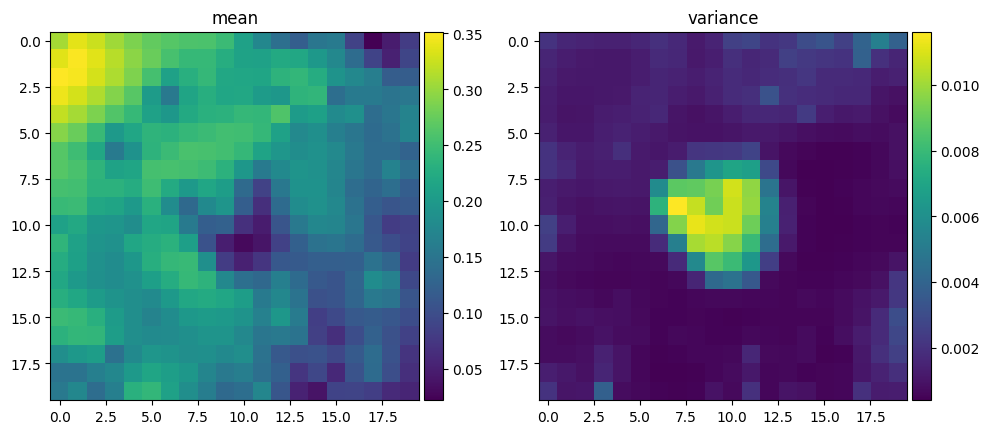

In [11]:
# Get predictions and plot results
gridded_mean, gridded_var = f.predict()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
im1 = ax1.imshow(gridded_mean[0])
ax1.set_title('mean')
im2 = ax2.imshow(gridded_var[0])
ax2.set_title('variance')

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

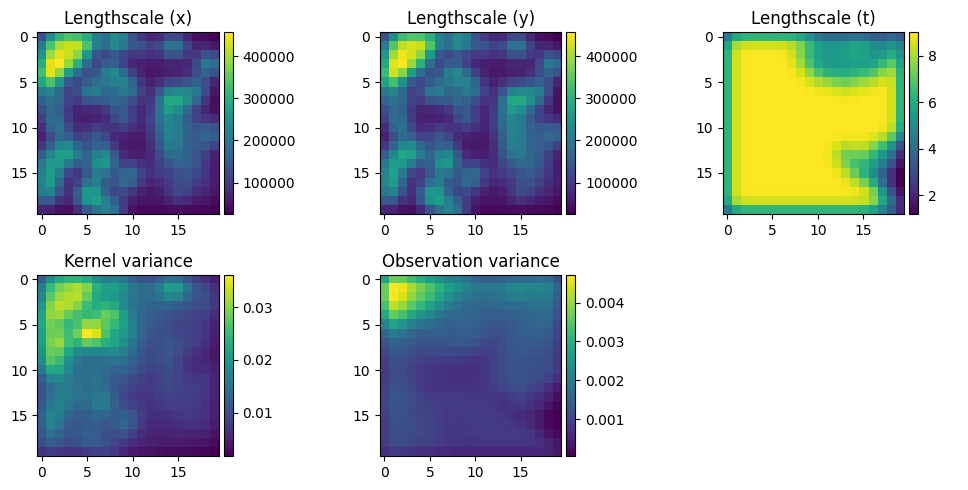

In [9]:
# Plot hyperparameter fields
ds = xr.open_dataset(f'log/hyperparameters_{dates[0]}_50km.nc')
fig, axs = plt.subplots(2,3, figsize=(10,5))

def add_colorbar(image, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(image, cax=cax, orientation='vertical') 

im1 = axs[0,0].imshow(ds['lengthscale_x'])
axs[0,0].set_title('Lengthscale (x)')
add_colorbar(im1, axs[0,0])

im2 = axs[0,1].imshow(ds['lengthscale_y'])
axs[0,1].set_title('Lengthscale (y)')
add_colorbar(im2, axs[0,1])

im3 = axs[0,2].imshow(ds['lengthscale_t'])
axs[0,2].set_title('Lengthscale (t)')
add_colorbar(im3, axs[0,2])

im4 = axs[1,0].imshow(ds['kernel_variance'])
axs[1,0].set_title('Kernel variance')
add_colorbar(im4, axs[1,0])

im5 = axs[1,1].imshow(ds['observation_variance'])
axs[1,1].set_title('Observation variance')
add_colorbar(im5, axs[1,1])

axs[1,2].set_axis_off()

plt.tight_layout()
plt.show()